# 1. Install Dependencies and Setup

In [ ]:
%pip install tensorflow opencv-python matplotlib

In [ ]:
%pip list

In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [3]:
import cv2
import imghdr

C:\Users\User\AppData\Local\Temp\ipykernel_10324\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [35]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [36]:
data_iterator = data.as_numpy_iterator()

In [42]:
batch = data_iterator.next()
np.shape(batch[0])

(32, 256, 256, 3)

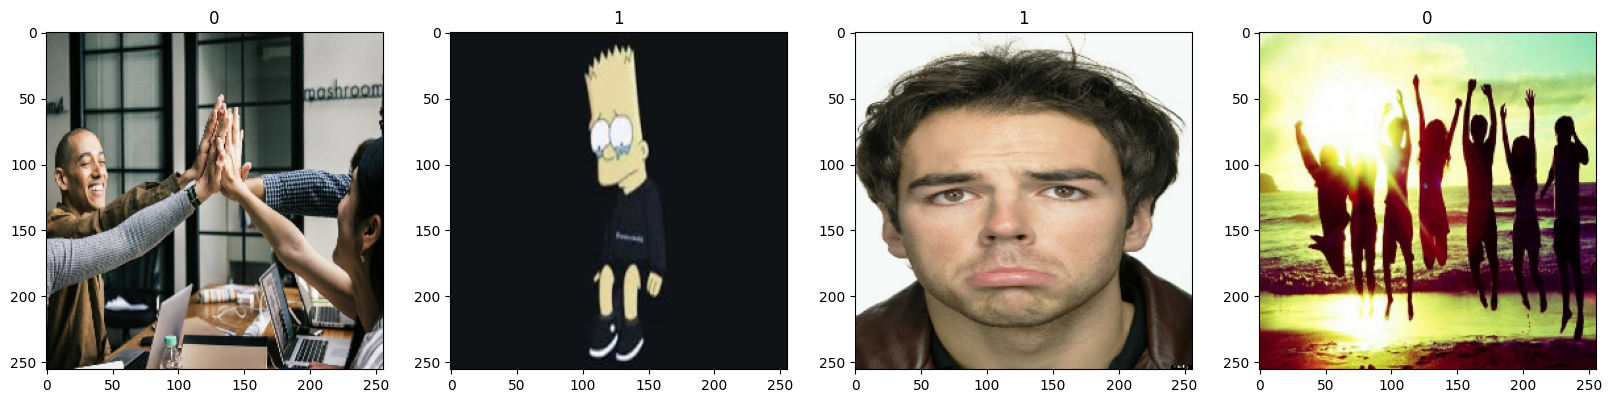

In [43]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [44]:
data = data.map(lambda x,y: (x/255, y))

In [45]:
data.as_numpy_iterator().next()

(array([[[[0.99607843, 0.99215686, 0.972549  ],
          [0.9927083 , 0.98912376, 0.9678309 ],
          [0.9773897 , 0.975337  , 0.9463848 ],
          ...,
          [0.9865503 , 0.9807598 , 0.9480699 ],
          [0.99114585, 0.9868873 , 0.96492034],
          [0.99215686, 0.9882353 , 0.96862745]],
 
         [[0.99607843, 0.99215686, 0.972549  ],
          [0.9927083 , 0.98912376, 0.9678309 ],
          [0.9773897 , 0.975337  , 0.9463848 ],
          ...,
          [0.9865503 , 0.9807598 , 0.9480699 ],
          [0.99114585, 0.9868873 , 0.96492034],
          [0.99215686, 0.9882353 , 0.96862745]],
 
         [[0.99607843, 0.99215686, 0.972549  ],
          [0.9927083 , 0.98912376, 0.9678309 ],
          [0.9773897 , 0.975337  , 0.9463848 ],
          ...,
          [0.9865503 , 0.9807598 , 0.9480699 ],
          [0.99114585, 0.9868873 , 0.96492034],
          [0.99215686, 0.9882353 , 0.96862745]],
 
         ...,
 
         [[0.9716299 , 0.96770835, 0.9520221 ],
          [0.97214

# 5. Split Data

In [52]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [51]:
train_size+val_size+test_size

10

In [48]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [56]:
model = Sequential()

In [57]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [58]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [98]:
logdir='logs'

In [97]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [62]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 886ms/step - accuracy: 0.4540 - loss: 1.5545 - val_accuracy: 0.6250 - val_loss: 0.6867
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 923ms/step - accuracy: 0.6023 - loss: 0.6902 - val_accuracy: 0.6406 - val_loss: 0.6596
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 908ms/step - accuracy: 0.6383 - loss: 0.6551 - val_accuracy: 0.6719 - val_loss: 0.5964
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 994ms/step - accuracy: 0.7148 - loss: 0.5750 - val_accuracy: 0.8125 - val_loss: 0.5426
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 848ms/step - accuracy: 0.7153 - loss: 0.5339 - val_accuracy: 0.7031 - val_loss: 0.5154
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 856ms/step - accuracy: 0.8019 - loss: 0.4849 - val_accuracy: 0.7500 - val_loss: 0.4778
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 837ms/step - accuracy: 0.8903 - loss: 0.3657 - val_accuracy: 0.8750 - val_loss: 0.3323
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 845ms/step - accuracy: 0.9219 - loss: 0.2906 - val_accuracy: 0.8750 - val_loss

# 8. Plot Performance

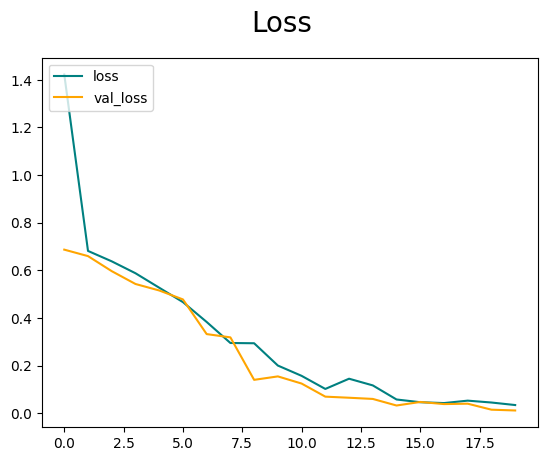

In [99]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

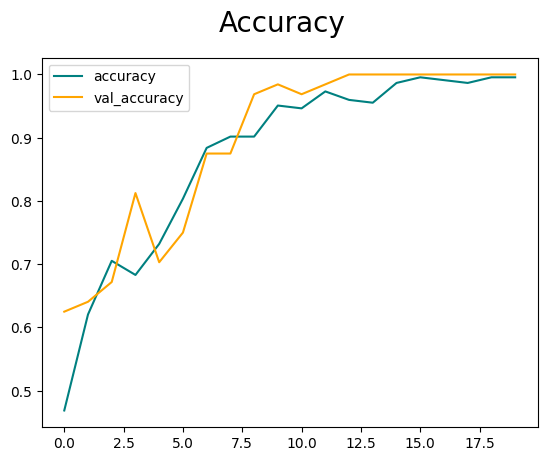

In [100]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [65]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [66]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [67]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


In [68]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [69]:
import cv2

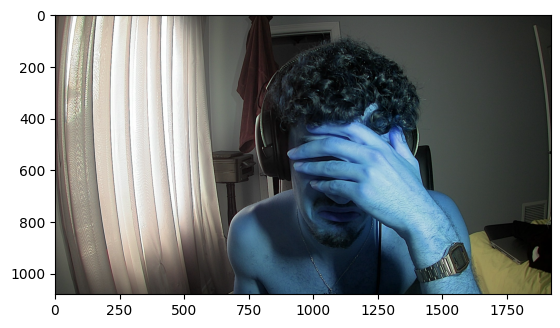

In [92]:
img = cv2.imread('sad.jpg')
plt.imshow(img)
plt.show()

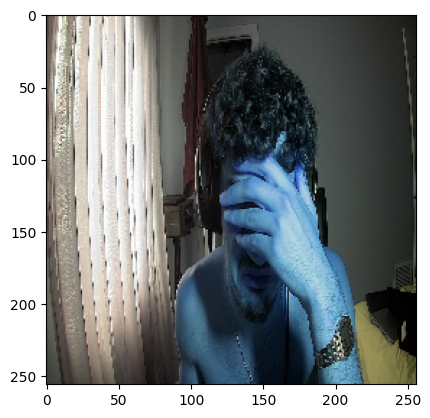

In [93]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [94]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [95]:
yhat

array([[0.331248]], dtype=float32)

In [96]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [101]:
from tensorflow.keras.models import load_model

In [104]:
model.save(os.path.join('models','imageclassifier.h5'))

In [107]:
new_model = load_model('models/imageclassifier.h5')

In [108]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


array([[0.331248]], dtype=float32)